# Jan Izydorczyk

# Sprawozdanie 7

In [1]:
from matplotlib import pyplot as plt
import math
import numpy as np
import random
import scipy
import sys
%matplotlib notebook

print("Wersja Pythona:")
print (sys.version)
print(f"Wersja numpy: {np.__version__}")
print("Konfiguracja liczb zmiennoprzecinkowych")
print(sys.float_info)

f64 = np.float64
f32 = np.float32

Wersja Pythona:
3.9.4 (tags/v3.9.4:1f2e308, Apr  6 2021, 13:40:21) [MSC v.1928 64 bit (AMD64)]
Wersja numpy: 1.20.2
Konfiguracja liczb zmiennoprzecinkowych
sys.float_info(max=1.7976931348623157e+308, max_exp=1024, max_10_exp=308, min=2.2250738585072014e-308, min_exp=-1021, min_10_exp=-307, dig=15, mant_dig=53, epsilon=2.220446049250313e-16, radix=2, rounds=1)


In [2]:
import networkx as nx
import graphviz as gv

 # Zadanie 1

In [3]:
A1 = np.array([
     [7, 1, -1, 2],
     [1, 8, 0, -2],
     [-1, 0, 4, -1],
     [2, -2, -1, 6]
 ], dtype=f64)
b1 = np.array([3, -5, 4, -3], dtype=f64)
b1.shape=(-1, 1)
sol1 = np.linalg.solve(A1, b1)
E1 = (A1, b1, sol1)

In [4]:
 A2 = np.array([
     [7, 3, -1, 2],
     [3, 8, 1, -4],
     [-1, 1, 4, -1],
     [2, -4, -1, 6]
 ], dtype=f64)
b2 = np.array([-1, 0, -3, 1], dtype=f64)
b2.shape=(-1, 1)
sol2 = np.linalg.solve(A2, b2)
E2 = (A2, b2, sol2)

In [5]:
def remove_zeros_from_diagonal(M, b):
    M = np.copy(M)
    b = np.copy(b)
    for idx in range(M.shape[0]):
        max_idx = np.argmax(np.abs(M[idx:, idx])) + idx
        M[[idx, max_idx]] = M[[max_idx, idx]]
        b[[idx, max_idx]] = b[[max_idx, idx]]
    return M, b

In [6]:
def solver_(method):
    def wrapper(A, b, sol=None, epsilon=None, *args, x_t=None, max_steps=None, epsilons_buf=None,  **kwargs):
        A, b = remove_zeros_from_diagonal(A, b)
        maxes = np.column_stack((np.max(np.abs(A), axis=1),b))
        maxes = np.max(maxes, axis=1).reshape(-1, 1)
        A /= maxes
        b /= maxes
        if x_t is None:
            x_t = np.random.rand(*b.shape)
        else:
            x_t = np.copy(x_t)
        def pred(x,steps):
            nonlocal epsilon, sol
            res = False
            if sol is not None and epsilon is not None:
                res =  not np.allclose(x, sol, atol=epsilon)
            elif max_steps is not None:
                res = steps < max_steps
            if res and sol is not None and epsilons_buf is not None:
                epsilons_buf.append(np.mean(np.abs(x - sol)))
            return res
        return method(A, b, sol, epsilon, *args, x_t=x_t, max_steps=max_steps, epsilons_buf=epsilons_buf, pred=pred, **kwargs)
    return wrapper

In [7]:
x_0 = np.random.rand(*E1[1].shape)

## Metoda Jacobiego 

In [8]:
@solver_
def solve_jacoby(A, b, sol, epsilon, x_t=None, max_steps=None, epsilons_buf=None, pred=None):
    # M = I - B^-1 * A 
    # W = B^-1 * b
    n = A.shape[0]
    A = np.copy(A)
    D_1 = np.diag(1 / np.diag(A))
    M = np.eye(n) - D_1 @ A
    W = D_1 @ b
    steps = 0
    while pred(x_t, steps):
        steps += 1
        x_t = M @ x_t + W
        
    return x_t, steps

In [9]:
res, steps = solve_jacoby(*E1, epsilon=1e-4, x_t=x_0)
print(f'Jacoby in first eqs system needs {steps} steps for 1e-4 precision.')

Jacoby in first eqs system needs 14 steps for 1e-4 precision.


In [10]:
res, steps = solve_jacoby(*E2, epsilon=1e-4, x_t=x_0)
print(f'Jacoby in second eqs system needs {steps} steps for 1e-4 precision.')

Jacoby in second eqs system needs 71 steps for 1e-4 precision.


## Metoda Gaussa-Seidla

In [11]:
@solver_
def solve_gauss_seidl(A, b, sol, epsilon, x_t=None, max_steps=None, epsilons_buf=None, pred=None):
    # M = I - B^-1 * A 
    # W = B^-1 * b
    # B = L + D
    n = A.shape[0]
    steps = 0
    while pred(x_t, steps):
        steps += 1
        for i in range(n):
            x_t[i, 0] = (b[i, 0] - np.dot(A[i, :], x_t ) + A[i,i]*x_t[i, 0] ) / A[i,i]
    return x_t, steps

In [12]:
res, steps = solve_gauss_seidl(*E1, epsilon=1e-4, x_t=x_0)
print(f'Gaussa-Seidle in second eqs system needs {steps} steps for 1e-4 precision.')

Gaussa-Seidle in second eqs system needs 8 steps for 1e-4 precision.


In [13]:
res, steps = solve_gauss_seidl(*E2, epsilon=1e-4, x_t=x_0)
print(f'Gaussa-Seidle in second eqs system needs {steps} steps for 1e-4 precision.')

Gaussa-Seidle in second eqs system needs 36 steps for 1e-4 precision.


## Metoda SOR

In [14]:
@solver_
def solve_sor(A, b, sol, epsilon, omega, x_t=None, max_steps=None, epsilons_buf=None, pred=None):
    # M = I - B^-1 * A 
    # W = B^-1 * b
    # B = L + D
    n = A.shape[0]
    steps = 0
    while pred(x_t, steps):
        steps += 1
        for i in range(n):
            x_t[i, 0] = (1 - omega) * x_t[i, 0] + omega * (b[i, 0] - np.dot(A[i, :], x_t ) + A[i,i]*x_t[i, 0] ) / A[i,i]
    return x_t, steps

In [15]:
res, steps = solve_sor(*E1, omega=1.1, epsilon=1e-4, x_t=x_0)
print(f'SOR in first eqs system needs {steps} steps for 1e-4 precision.')

SOR in first eqs system needs 5 steps for 1e-4 precision.


In [16]:
res, steps = solve_sor(*E2, omega=1.4, epsilon=1e-4, x_t=x_0)
print(f'SOR in second eqs system needs {steps} steps for 1e-4 precision.')

SOR in second eqs system needs 11 steps for 1e-4 precision.


## Testy

Jako, że nie zostało sprecyzowane, w jaki sposób liczyć błąd przybliżenia, obliczana jest średnia odległość kolejnych współrzędnych od kolejnych współrzędnych prawidłwego rozwiązania. 

In [17]:
def plot_conv(E, method, *args, steps=None, x_0=None, fig=None, label=''):
    if fig is None:
        fig = plt.figure()
    epsilons = []
    _, _ = method(*E, None, *args, max_steps=steps, epsilons_buf=epsilons)
    plt.plot(range(1, steps + 1), epsilons, label=label)
    
    return fig

In [18]:
def plot_comparison(E, max_steps, omega, name=''):
    b = E[1]
    x_0 = np.random.rand(*b.shape)
    fig = plot_conv(E, solve_jacoby, steps=max_steps, x_0=x_0, fig=None, label='Jacoby')
    fig = plot_conv(E, solve_gauss_seidl, steps=max_steps, x_0=x_0, fig=fig, label='Gauss Seidll')
    fig = plot_conv(E, solve_sor, omega, steps=max_steps, x_0=x_0, fig=fig, label='SOR')

    fig.suptitle(f'Comparisons for {name}')
    plt.yscale('log')
    plt.legend()
    plt.xlabel('Number of steps')
    plt.ylabel('Epsilon')
    fig.tight_layout()

    plt.show()

<IPython.core.display.Javascript object>


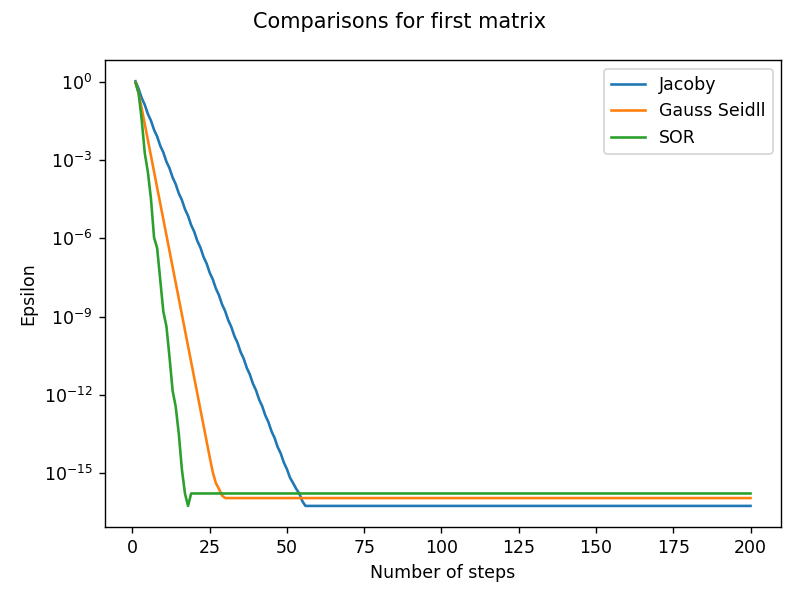

In [21]:
plot_comparison(E1, 200, omega=1.1, name='first matrix')

<IPython.core.display.Javascript object>


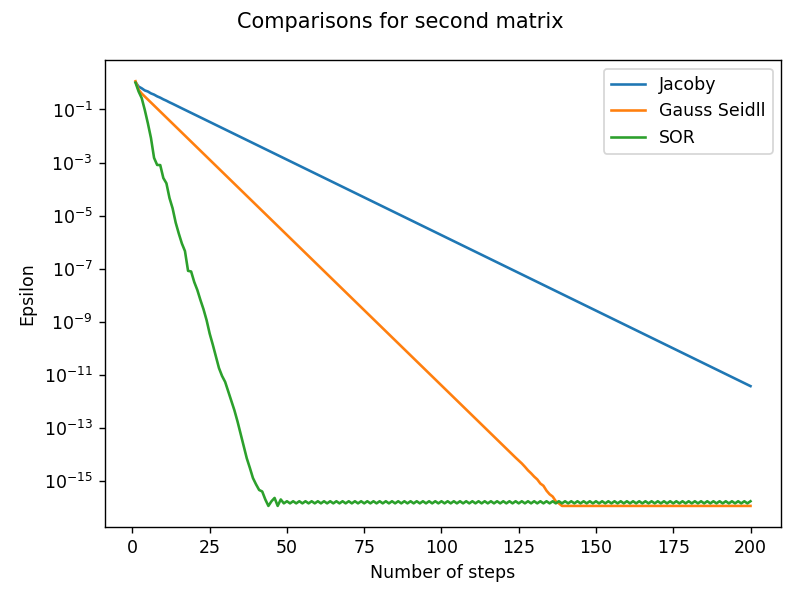

In [21]:
plot_comparison(E2, 200, omega=1.4, name='second matrix')

## Wnioski

Zgodnie z przewidywaniami teoretycznymi, dla każdej z metod wykładnik błędu zmniejsza się liniowo, względem, liczby ktroków iteracji. Metody odróżnia natomiast nachylenie prostej (zatem stała), gdzie dla obu układów równań najszybsza okazała się metoda *SOR*, następnie *Gauss-Seidlla*, a na najgorsza metoda *Jacobiego*.



Należy zauważyć, że każda z metod osiągneła minimalny błąd w okolicach wartości $10^{-15}$. Wynika to bezpośrednio z dokładności reprezentacji zmiennoprzecinkowej.

# Zadanie 2

W reprezentacji grafowej każdy przewód ma losowy, aczkolwiek ustalony od samego początku aż do końca kierunek płynięcia prądu (co reprezentowane jest przez znak wartości oporu prądu).

In [126]:
from graphviz import Digraph

from itertools import chain

def circuit_graph(edges, E):
    print()
    H = nx.DiGraph()
    beg = (E[0], E[1])
    for a, b, w in edges:
        H.add_edge(a, b)
        H.add_edge(b, a)
        H[a][b]['res'] = w
        H[b][a]['res'] = -w
        if (a, b) == beg or (b, a) == beg:
            H[a][b]['vol'] = E[2]
            H[b][a]['vol'] = -E[2]
    return H
   

In [127]:
def draw_circuit(H, unit='', title='', label='res', pos=None):
    if isinstance(H, nx.DiGraph):
        H = H.to_undirected()
        for a, b in H.edges:
            H[a][b][label] = abs(H[a][b][label])
    fig = plt.figure()     
            
    ax = plt.gca()
    ax.set_title(title)
    
    edge_labels=dict( [( (u,v,), str(np.round(d[label], 2)) + unit )for u,v,d in H.edges(data=True)] )
    if pos is None:
        pos =  nx.circular_layout(H)
    nx.draw_networkx_edge_labels(H,pos=pos,edge_labels=edge_labels, ax=ax)
    nx.draw_networkx(H, pos, ax=ax)
    fig.tight_layout()
    plt.show()

In [128]:
C = circuit_graph([
    (2, 4, 7),
    (2, 3, 2),
    (2, 5, 5),
    (3, 6, 4),
    (3, 4, 6),
    (4, 5, 11),
    (4, 6, 9),
    (5, 6, 1),
], (4, 2, 300))

<IPython.core.display.Javascript object>


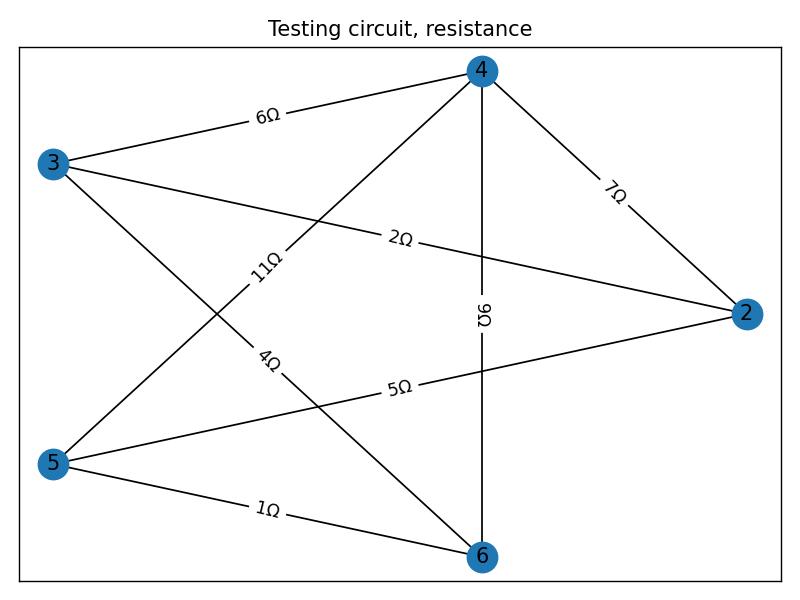

In [129]:
draw_circuit(C, unit='$\Omega$', title='Testing circuit, resistance')

Na początku znajdowane są bazowe cykle w grafie i interpretowane jako oczka w sieci. Na ich podstawie tworzone są pierwsze równania (respektujące wcześniej ustalony kierunek prądu).

Następnie, dla węzłów w sieci następne równania powstają zgodnie z zasadą zachowania ładunku w układzie (ponownie, kierunek prądu ma znaczenie).  

In [130]:

def solve_circuit(C, solver):
    uC = C.to_undirected()
    cycles = nx.algorithms.cycles.cycle_basis(uC)
    
    to_idx_dict = dict(zip(uC.edges, range(len(uC.edges))))
    n = len(to_idx_dict)
    def to_idx(a,b):
        nonlocal to_idx_dict
        return to_idx_dict.get((a, b), to_idx_dict.get((b, a)))
    
    M = np.zeros((n, n))
    Y = np.zeros((n, 1))
    for idx, c in enumerate(cycles):
        for i in range(len(c)):
            a, b = c[i], c[(i+1)%len(c)]
            if 'vol' in C[a][b]:
                Y[idx] = C[a][b]['vol']
            M[idx][to_idx(a, b)] = C[a][b]['res']
    idx = len(cycles)
    for v, idx in zip(C.nodes, range(len(cycles),  n)):
        for nbor in uC.neighbors(v):
            M[idx][to_idx(v, nbor)] = np.sign(C[v][nbor]['res'])
    
    X = solver(M, Y)
    print(X)
    for (a, b), idx in to_idx_dict.items():
        C[a][b]['cur'] = X[idx] 
        C[b][a]['cur'] = -X[idx]
    return C
    
    

In [131]:
C_I = solve_circuit(C, lambda A, b: solve_jacoby(A, b, max_steps=90)[0]) # np.linalg.solve

[[-3.90672370e+31]
 [-2.11075445e+32]
 [ 1.65611422e+32]
 [ 2.04568255e+31]
 [ 6.41121982e+30]
 [-3.21926394e+31]
 [-1.38225261e+32]
 [-3.93133982e+31]]


<IPython.core.display.Javascript object>


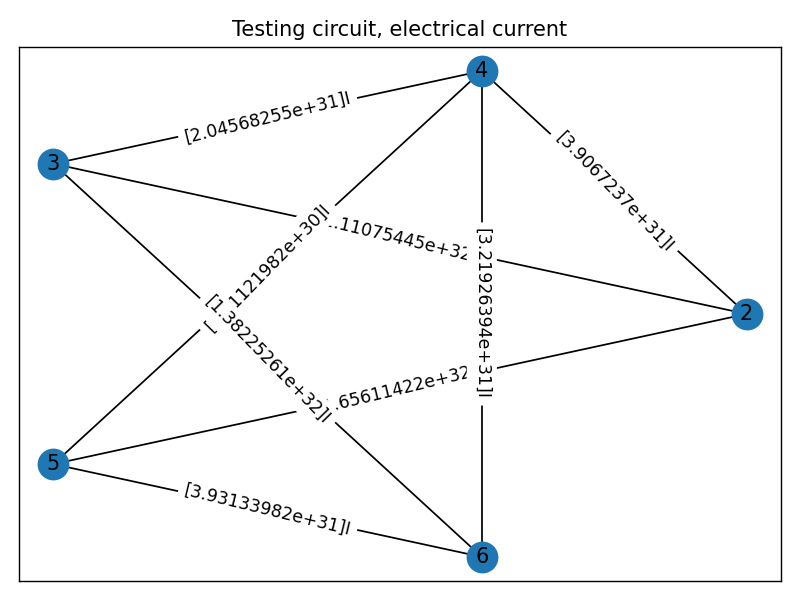

In [132]:
draw_circuit(C_I, unit='I', title='Testing circuit, electrical current', label='cur')

Niestety, dla zadanego układu promień spektralny jest większy niż 1 i metody iteracyjne nie są zbieżne.

Podczas kolejnych testów uzyta zostanie funkcja biblioteczna *np.linalg.solve*.

In [133]:
C_I = solve_circuit(C, np.linalg.solve) 

[[ 26.54915785]
 [-17.19545633]
 [ -9.35370153]
 [-13.29416373]
 [  6.12612613]
 [  7.128868  ]
 [ -3.9012926 ]
 [ -3.2275754 ]]


<IPython.core.display.Javascript object>


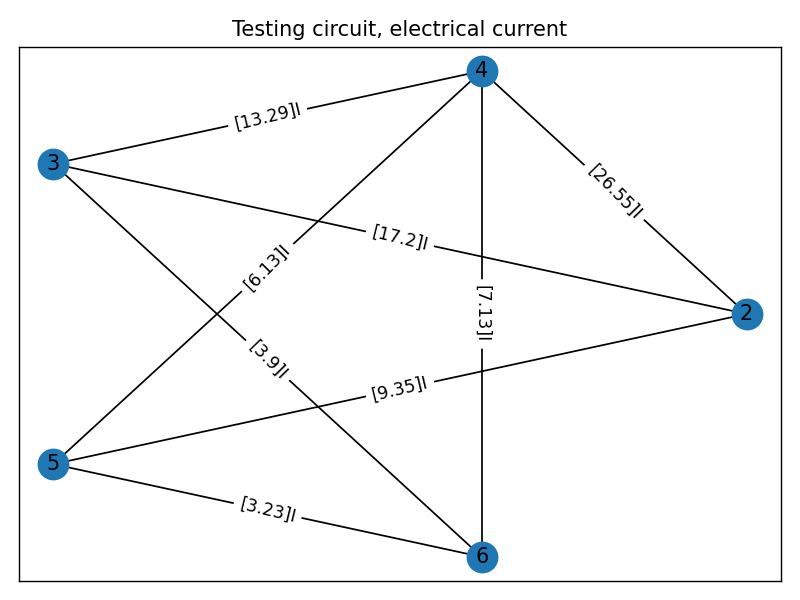

In [134]:
draw_circuit(C_I, unit='I', title='Testing circuit, electrical current', label='cur')

Wartości natężenia zdają się zgadzać z podanymi w zadaniu. 

## Testy

Funkcja sprawdza czy rozwiązanie spełnia prawa Kirchoffa.

In [135]:
def check_circuit_solution(C_I, epsilon=1e-6):
    uC = C.to_undirected()
    cycles = nx.algorithms.cycles.cycle_basis(uC)
    
    for cycle in cycles:
        expected = 0
        result = 0
        for i in range(len(cycle)):
            a, b = cycle[i], cycle[(i+1)%len(cycle)]
            if 'vol' in C_I[a][b]:
                expected = C_I[a][b]['vol']
            result += C_I[a][b]['cur'] * abs(C_I[a][b]['res'])
        if abs(expected - result) > epsilon:
            return False
    
    for v in C_I.nodes:
        expected = 0
        result = 0
        for nbor in uC.neighbors(v):
            result +=  C[nbor][v]['cur']
        if abs(expected - result) > epsilon:
            return False
    return True

In [136]:
check_circuit_solution(C_I)

True

## Grafy losowe

In [114]:
def generate_circuit(graph_generator):
    graph = graph_generator()
    edges = [(a, b, random.randint(2, 14)) for a, b in graph.edges]
    E = (edges[0][0], edges[0][1], random.randint(1, 6) * 100)
    return circuit_graph(edges, E)

In [115]:
from itertools import combinations, groupby
def gnp_random_connected_graph(n, p=0.1):
    """
    Generates a random undirected graph, similarly to an Erdős-Rényi 
    graph, but enforcing that the resulting graph is conneted
    """
    edges = combinations(range(n), 2)
    G = nx.Graph()
    G.add_nodes_from(range(n))
    if p <= 0:
        return G
    if p >= 1:
        return nx.complete_graph(n, create_using=G)
    for _, node_edges in groupby(edges, key=lambda x: x[0]):
        node_edges = list(node_edges)
        random_edge = random.choice(node_edges)
        G.add_edge(*random_edge)
        for e in node_edges:
            if random.random() < p:
                G.add_edge(*e)
    return G

### Losowy graf spójny

<IPython.core.display.Javascript object>


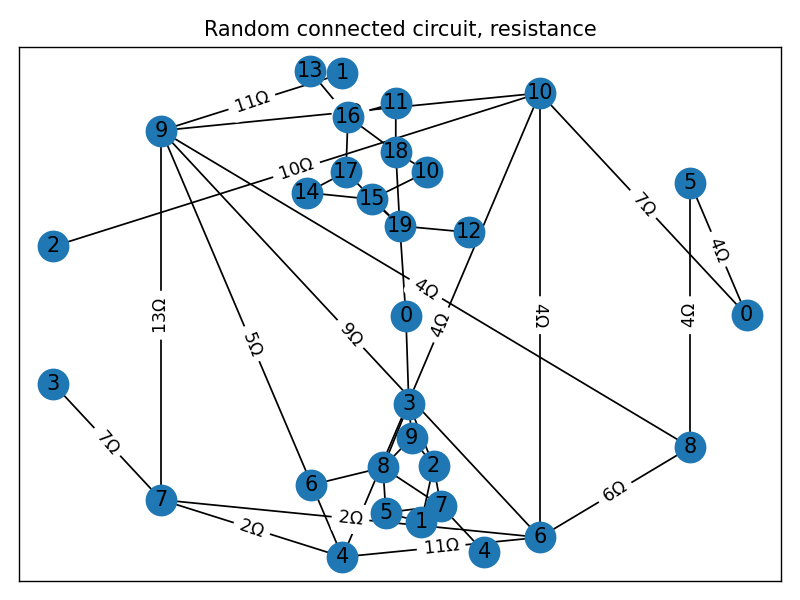

In [140]:
C = generate_circuit(lambda: gnp_random_connected_graph(11, 0.15))
draw_circuit(C, title='Random connected circuit, resistance', unit='$\Omega$')

[[ 1.05737158e+01]
 [-1.05737158e+01]
 [ 1.05737158e+01]
 [-8.88178420e-16]
 [ 2.68977982e+00]
 [ 3.63012643e+00]
 [ 4.25380955e+00]
 [ 0.00000000e+00]
 [-1.25122378e+00]
 [-2.77192496e-01]
 [-3.12530406e-01]
 [ 6.09475623e+00]
 [ 0.00000000e+00]
 [-1.09661181e+00]
 [ 7.84081408e-01]
 [-3.41944222e-01]
 [-4.47895956e+00]]


<IPython.core.display.Javascript object>


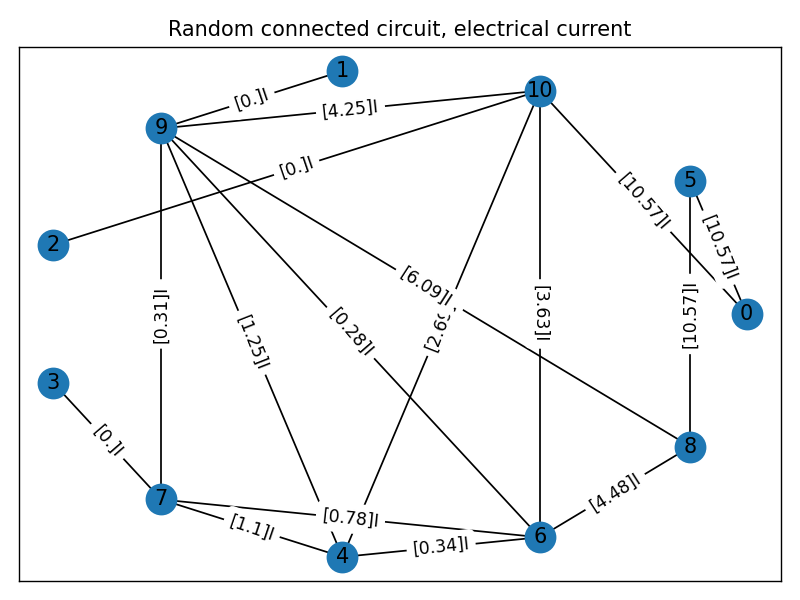

In [142]:
C_I = solve_circuit(C, np.linalg.solve)
draw_circuit(C_I, title='Random connected circuit, electrical current', unit='I', label='cur')

In [118]:
check_circuit_solution(C_I)

True

### Losowy graf kubiczny

<IPython.core.display.Javascript object>


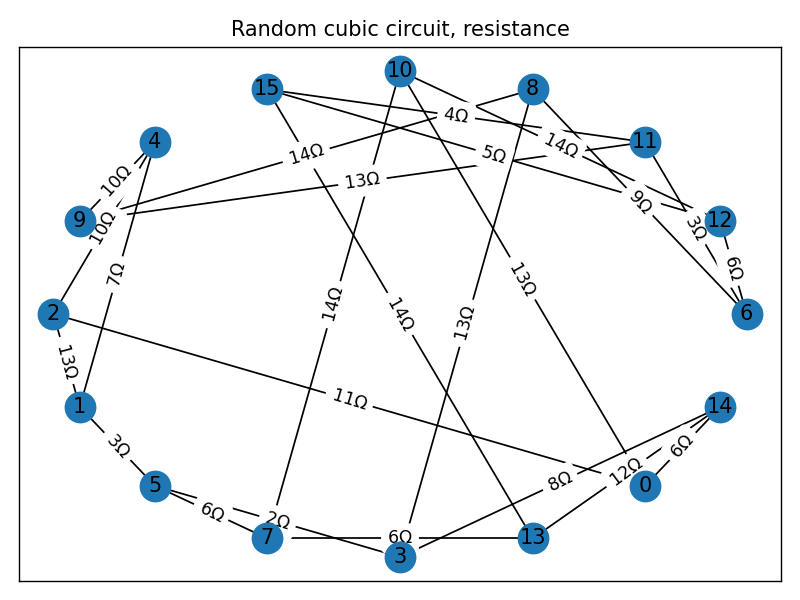

In [119]:
C = generate_circuit(lambda: nx.random_regular_graph(3, 16))
draw_circuit(C, title='Random cubic circuit, resistance', unit='$\Omega$')

[[ 26.17046813]
 [-20.52095237]
 [ -5.64951576]
 [  5.60996039]
 [ 20.56050773]
 [  0.86800351]
 [-19.65294886]
 [  1.57151864]
 [ -4.07799712]
 [ -2.74393464]
 [ -2.86602576]
 [ -0.90755887]
 [  2.43952214]
 [ -1.25440855]
 [ -1.1851136 ]
 [  1.58120011]
 [  0.32679156]
 [  0.85832203]
 [ -2.98496256]
 [  2.12664053]
 [ -0.24102793]
 [  1.95135659]
 [ -0.66653094]
 [  1.28482564]]
(6, 11)
(6, 8)
(11, 9)
(11, 15)
(8, 9)
(8, 3)
(4, 2)
(4, 1)
(2, 0)
(1, 5)
(5, 7)
(7, 13)
(3, 14)


<IPython.core.display.Javascript object>


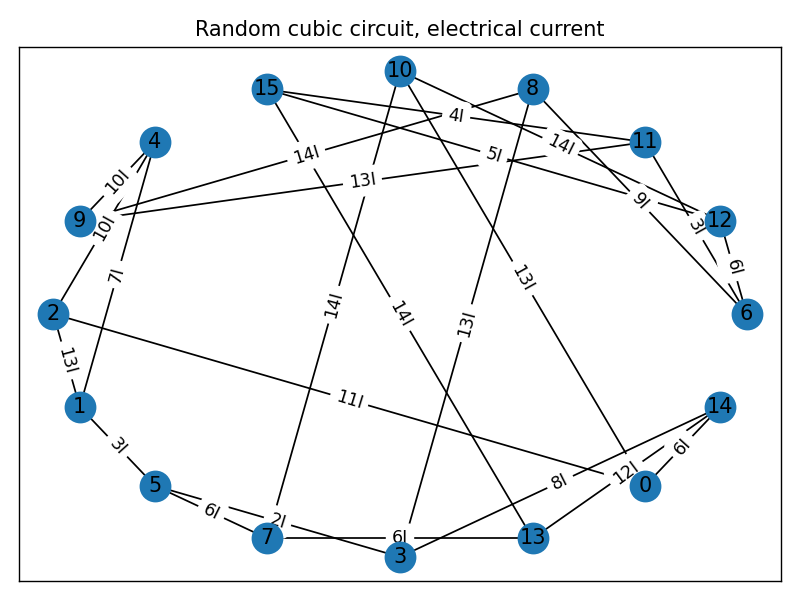

In [120]:
C_I = solve_circuit(C, np.linalg.solve)
draw_circuit(C_I, title='Random cubic circuit, electrical current', unit='I')

In [146]:
check_circuit_solution(C_I)

True

### Losowy graf siatki 2d

<IPython.core.display.Javascript object>


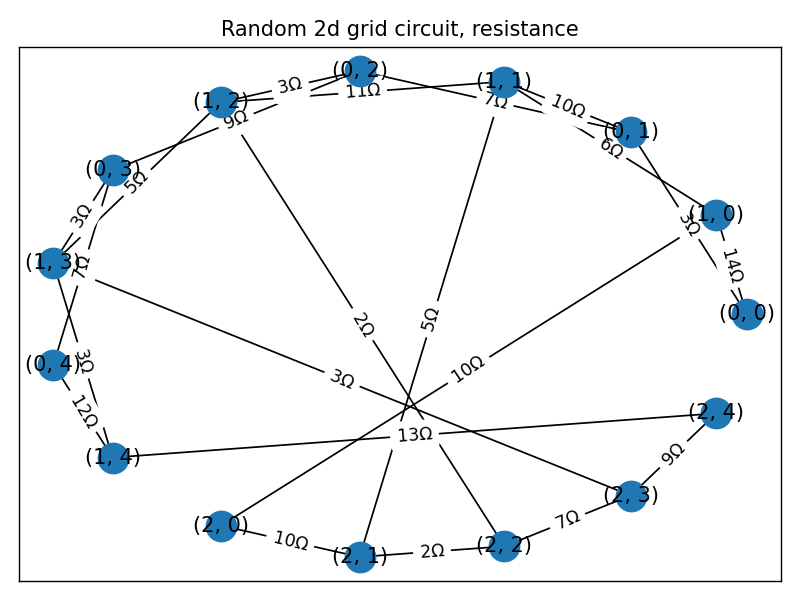

In [147]:
C = generate_circuit(lambda: nx.grid_2d_graph(3, 5))
draw_circuit(C, title='Random 2d grid circuit, resistance', unit='$\Omega$')

[[ 14.74084338]
 [-14.74084338]
 [  3.58844289]
 [ 11.15240048]
 [ -8.24912597]
 [ -6.4917174 ]
 [  0.97089099]
 [  1.93238352]
 [ -5.26433971]
 [ -1.22737769]
 [ -3.64154803]
 [  0.30959184]
 [ -1.06622024]
 [ -0.16115745]
 [ -0.80218478]
 [  0.04555638]
 [ -0.16115745]
 [ -0.11560107]
 [  3.58844289]
 [  4.55933388]
 [  0.91778585]
 [  0.11560107]]


<IPython.core.display.Javascript object>


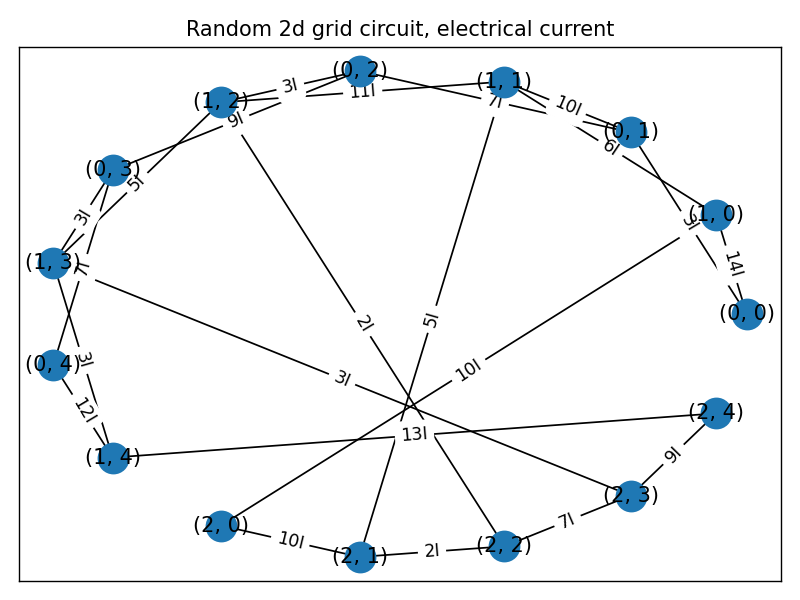

In [148]:
C_I = solve_circuit(C, np.linalg.solve)
draw_circuit(C_I, title='Random 2d grid circuit, electrical current', unit='I')

In [149]:
check_circuit_solution(C_I)

True

### Losowy graf powstały z połaczenia dwóch grafów spójnych mostkiem 

In [150]:
def gnp_two_random_connected_graph(n, m, p=0.1):
    A = gnp_random_connected_graph(n, p)
    B = gnp_random_connected_graph(m, p)    
    U=nx.disjoint_union(A,B)
    U.add_edge(0, len(U.nodes) - 1)
    return U

In [151]:
G = gnp_two_random_connected_graph(10, 10, 0.1)
nx.draw_networkx(G)

<IPython.core.display.Javascript object>


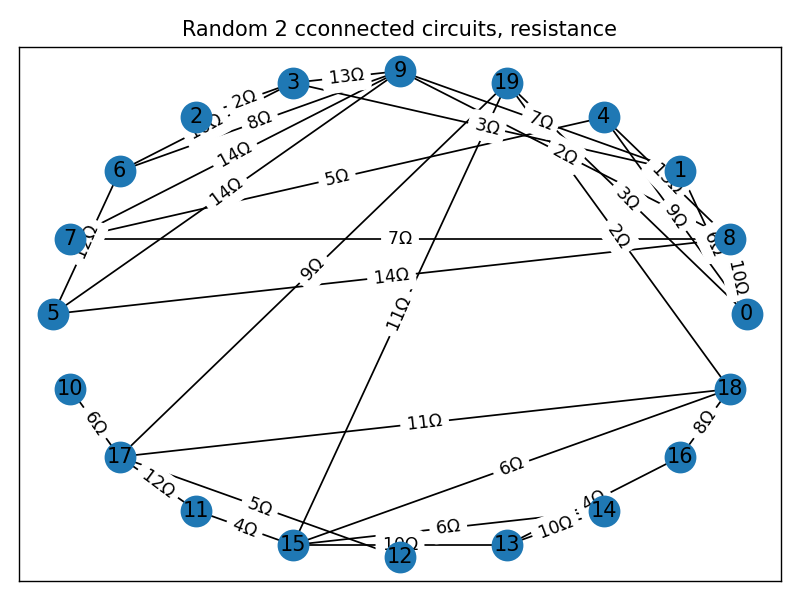

In [155]:
C = generate_circuit(lambda: gnp_two_random_connected_graph(10, 10, 0.15))
draw_circuit(C, title='Random 2 cconnected circuits, resistance', unit='$\Omega$')

[[ 3.00232019e+01]
 [-1.67004948e+01]
 [-1.33227071e+01]
 [ 5.35964743e-16]
 [-6.14335512e+00]
 [-1.90404675e+00]
 [-6.28097949e+00]
 [ 1.56948206e+01]
 [-9.73933871e+00]
 [-6.96115607e+00]
 [-7.17935202e+00]
 [-3.15850891e-16]
 [-2.20113852e-16]
 [-0.00000000e+00]
 [-3.63783868e+00]
 [ 3.38070468e-01]
 [-1.75734111e+00]
 [-8.98372525e-01]
 [ 0.00000000e+00]
 [-3.32331739e+00]
 [ 1.56597629e+00]
 [ 0.00000000e+00]
 [-9.33334461e-17]
 [-0.00000000e+00]
 [-1.80093151e-16]
 [ 9.33334461e-17]
 [ 1.17774909e-16]
 [ 7.36093179e-17]
 [-5.79059967e-16]
 [ 7.36093179e-17]
 [-1.91384226e-16]
 [-1.91384226e-16]]


<IPython.core.display.Javascript object>


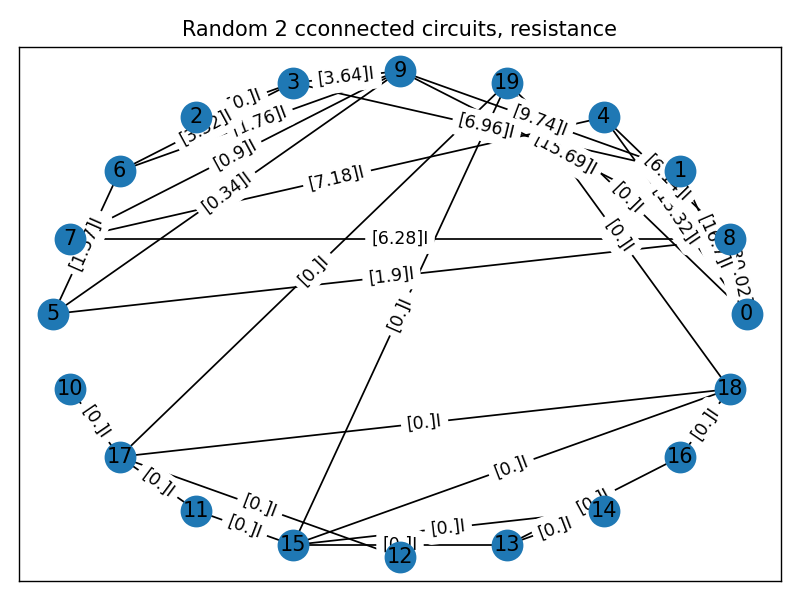

In [156]:
C_I = solve_circuit(C, np.linalg.solve)
draw_circuit(C_I, title='Random 2 cconnected circuits, resistance', unit='I', label='cur')

In [157]:
check_circuit_solution(C_I)

True